In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import matplotlib.ticker as ticker

In [2]:
# données 
data = pd.read_csv('UTF-8DataVacciniaVirus_0.csv')
time = data["Time (Days)"].values
N_avg, N_std = data["Naive (avg)"].values, data["Naive (std)"].values
A_avg, A_std = data["Effector (avg)"].values, data["Effector (std)"].values
M_avg, M_std = data["Memory (avg)"].values, data["Memory (std)"].values
tot_avg = N_avg + A_avg + M_avg

In [3]:
# Définition des modèles pour N(t), A(t) et M(t)

from scipy.interpolate import interp1d

N_interp_func = interp1d(time, N_avg, kind='linear', fill_value=(N_avg[0], 0), bounds_error=False)

def N_interp(t):
    return N_interp_func(t)


def model_A(t,params):
    """ Modèle On-Off pour A(t) """
    rho, alpha, r, T_on, T_off = params
    
    if t < T_on:
        return 0
    
    elif t <= T_off:
        # A(T_on)=50
        return 50 * np.exp(rho * (t - T_on))
    
    else:
        return  50* np.exp(rho * (T_off - T_on)) * np.exp(-(r + alpha) * (t - T_off))

def model_M(t, params):
    """ Modèle de formation des mémoires après T_off """
    rho, alpha, r, T_on, T_off = params
    delta_M = 1e-5
    
    if t < T_off:
        return 0
    
    else:
        A_Toff = 50 * (np.exp(rho * (T_off - T_on)) )
        return r / (r + alpha - delta_M) * A_Toff * (np.exp(-delta_M * (t - T_off)) - np.exp(-(r + alpha) * (t - T_off)))

In [4]:
# simulation et erreur 
def simulate(params, time):

    """ Simule N, A et M sur un vecteur de temps donné """
    A_vals = np.array([model_A(t, params) for t in time])
    M_vals = np.array([model_M(t, params) for t in time])
    N_vals = np.array([N_interp(t) for t in time])
    pred = A_vals + M_vals + N_vals
    return pred, A_vals, M_vals


def erreur(params, time, N_exp, A_exp, M_exp):
    """ Calcul de l'erreur pondérée entre modèle et données """
    pred, A_pred, M_pred = simulate(params, time)
    resid_pred = np.log1p(pred) - np.log1p(A_exp + M_exp + N_exp)
    resid_A = np.log1p(A_pred) - np.log1p(A_exp)
    resid_M = np.log1p(M_pred) - np.log1p(M_exp)
    return np.concatenate([resid_pred, resid_A, resid_M])

In [5]:
# Optimisation des paramètres 
initial_guess = [0.1, 1, 0.01, 1, 6]  # rho, alpha, r, T_on, T_off
result = least_squares(erreur, initial_guess, args=(time, N_avg, A_avg, M_avg), method='lm')
best_params = result.x
pred = simulate(best_params, time)[0]
ssr = np.sum((np.log1p(tot_avg) - np.log1p(pred))**2)
print("Paramètres optimisés :", best_params)
print("SSR = ", ssr )

Paramètres optimisés : [1.67459145 0.13838761 0.03410394 3.17222297 7.94373341]
SSR =  1.7516355469079712


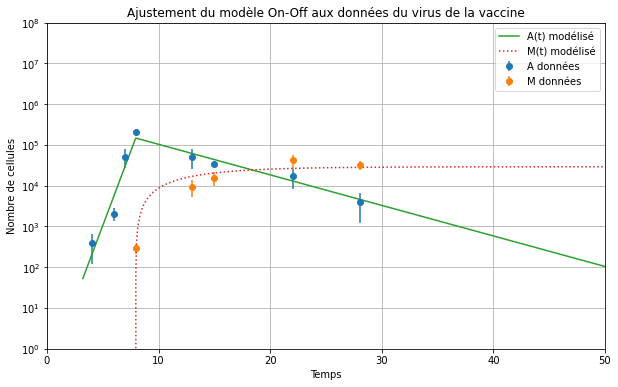

In [6]:
# visualisation
_,_,_,T_on,_ = best_params
plt.figure(figsize=(10, 6))
t_plot = np.linspace(0, 50, 1000)
tot_plot,A_plot, M_plot = simulate(best_params, t_plot)


plt.errorbar(time, A_avg, yerr=A_std, fmt='o', label="A données")
plt.errorbar(time, M_avg, yerr=M_std, fmt='o', label="M données")


mask_post = t_plot >= T_on
plt.plot(t_plot[mask_post], A_plot[mask_post], '-', label="A(t) modélisé")
plt.plot(t_plot, M_plot, ':', label="M(t) modélisé")


plt.yscale('log', base=10) 
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
plt.ylim(1e0, 1e8) 
plt.xlim(0,50)

plt.xlabel("Temps")
plt.ylabel("Nombre de cellules")
plt.legend()
plt.title("Ajustement du modèle On-Off aux données du virus de la vaccine")
plt.grid()
plt.savefig("vac_on_of.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
# Calcul de l'intervalle de confiance par bootstrap 
resid = erreur(best_params, time, N_avg, A_avg, M_avg)[:len(time)]
n_boot = 500
param_samples = []

for _ in range(n_boot):
    noise = np.random.choice(resid, size=len(resid), replace=True)
    new_log = np.log(1 + simulate(best_params, time)[0]) + noise
    y_boot = np.exp(new_log) - 1

    # Répartition entre A et M à partir des proportions initiales
    A_frac = A_avg / (A_avg + M_avg + 1e-9)
    A_boot = y_boot * A_frac
    M_boot = y_boot * (1 - A_frac)

    result_boot = least_squares(erreur, best_params, args=(time, N_avg, A_boot, M_boot), method='lm')
    param_samples.append(result_boot.x)

param_samples_array = np.array(param_samples)


param_names = ['rho', 'alpha', 'r', 'T_on', 'T_off']
for i, name in enumerate(param_names):
    low, high = np.percentile(param_samples_array[:, i], [2.5, 97.5])
    print(f"{name} = {best_params[i]:.4f} (IC 95%: [{low:.4f}, {high:.4f}])")


rho = 1.6746 (IC 95%: [1.0870, 1.6785])
alpha = 0.1384 (IC 95%: [0.0530, 0.1937])
r = 0.0341 (IC 95%: [0.0242, 0.0582])
T_on = 3.1722 (IC 95%: [1.0746, 3.0383])
T_off = 7.9437 (IC 95%: [7.9048, 7.9791])
